In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt

# loading data
df = pickle.load(open('dataset/df_2308', 'rb'))

# sorting the data in ascending order, starting from the most recent opdate
df.sort_values(by=['opdate'], ascending = True, inplace=True)#[['age_cal', 'sex', 'weight', 'height', 'cuffed']]

x = df[['age_cal', 'sex', 'weight', 'height', 'cuffed']].astype(float).values
y = df['airway_tube_size'].astype(float).values
c = df['opid'].values


x_cuffed = x[x[:,4] == 1][:,:4]
y_cuffed = y[x[:,4] == 1]

nsamp = len(y_cuffed)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_cuff_test = x_cuffed[-ntest:, :]
y_cuff_test = y_cuffed[-ntest:]
x_cuff_train = x_cuffed[:ntrain, :]
y_cuff_train = y_cuffed[:ntrain]

# traditional age-based formula (Duracher's formula : age / 4 + 3.5)
y_cuff_trad = np.array([math.floor((math.floor(age) / 4 + 3.5) * 2) / 2 if age >= 2 else (3.0 if age < 1 else 3.5) for age in x_cuff_test[:,0]], dtype=float)


x_uncuffed = x[x[:,4] == 0][:,:4]
y_uncuffed = y[x[:,4] == 0]

nsamp = len(y_uncuffed)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_uncuff_test = x_uncuffed[-ntest:, :]
y_uncuff_test = y_uncuffed[-ntest:]
x_uncuff_train = x_uncuffed[:ntrain, :]
y_uncuff_train = y_uncuffed[:ntrain]

# traditional age-based formula (trad1 = Cole's formula : age / 4 + 4, trad2 = Penlington's formula : age / 4 + 4.5)
y_uncuff_trad1 = np.array([math.floor((math.floor(age) / 4 + 4) * 2) / 2 if age >= 2 else (3.5 if age < 1 else 4) for age in x_uncuff_test[:,0]], dtype=float)
y_uncuff_trad2 = np.array([math.floor((math.floor(age) / 4 + 4.5) * 2) / 2 if age < 6.5 else math.floor((math.floor(age) / 3 + 3.5) * 2) / 2 for age in x_uncuff_test[:,0]], dtype=float)


print(f'x_cuff_train: {(x_cuff_train).shape}, x_cuff_test: {x_cuff_test.shape}')
print(f'x_uncuff_train: {(x_uncuff_train).shape}, x_uncuff_test: {x_uncuff_test.shape}')

x_cuff_train: (10712, 3), x_cuff_test: (2678, 3)
x_uncuff_train: (18934, 3), x_uncuff_test: (4733, 3)


In [135]:
np.savez(f'dataset/ETT_size_2308.npz', x=x, y=y, c=c)

In [80]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt

dat = np.load(f'dataset/ETT_size-outliers3.npz')
#df = pickle.load(open('dataset/df-outliers3', 'rb'))
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용 (이미 shuffle된 상태)
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')

x_train: (24764, 5), x_test: (6190, 5)


# Reviewer 1

# COMMENT 0-1

In [2]:
def remove_outliers(df, col_name):
    out_hids = set()
    for i in range(0,0):
        df2 = df.loc[(i/2<=df['age_cal'])&(df['age_cal']<i/2+0.5), [col_name,'hid']]

        # normalization
        from sklearn.preprocessing import StandardScaler
        
        sc = StandardScaler()
        znorm = sc.fit_transform(df2[[col_name]]).flatten()
        out_mask = (znorm > 2) | (znorm < -2)

        #std0, mean0 = df2.std()[0], df2.mean()[0]
        #print(f'age {i/2}~{i/2+0.5}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
        out_hids = out_hids | set((df2['hid'].values)[out_mask])

        
    for i in range(0,10):
        df2 = df.loc[df['age']==i, [col_name,'hid']]

        # normalization
        from sklearn.preprocessing import StandardScaler
        
        sc = StandardScaler()
        znorm = sc.fit_transform(df2[[col_name]]).flatten()
        out_mask = (znorm > 2) | (znorm < -2)

        #std0, mean0 = df2.std()[0], df2.mean()[0]
        #print(f'age {i}~{i+1}: {np.sum(out_mask)}/{len(df2)} (범위:{mean0 - std0 * 2:.2f}~{mean0 + std0 * 2:.2f})')
        out_hids = out_hids | set((df2['hid'].values)[out_mask])
        
        

    # outlier에 해당하는 hid 제외
    hmask = df['hid'].apply(lambda x: x not in out_hids)
    
    return df.loc[hmask.values]

In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, math
import matplotlib.pyplot as plt
import numpy as np
import csv

### birth date, op date 없는 환자 중 소아는 거의 없음 (94,914 중 5명) -> 정석대로 birth, op date로 age 계산해서 진행
# tube.csv에 수술 시점 weight, height 추가
df0 = pd.read_csv('tube.csv')
df0.drop(columns=['weight', 'height'], inplace=True)
df = pd.read_csv('demography_revised.csv')
df = df0.merge(df[['opid', 'weight', 'height']], how='left', on='opid', suffixes=('_o',''))

df.loc[df['weight'] <= 1, 'weight'] = None
df.loc[df['weight'] > 200, 'weight'] = None
df.loc[df['height'] <= 30, 'height'] = None
df.loc[df['height'] > 230, 'height'] = None
df['age'] = df['age'].astype(int)

# 나이 계산 -> age_cal 열에 추가
df_b = pd.read_csv('birth_sex.csv')
df_b.rename(columns={'생년월일':'birth_date'}, inplace=True)
df_b['birth_date'] = df_b['birth_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df_o = pd.read_csv('opdates.csv')
df_o['opdate'] = df_o['opdate'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

df1 = pd.merge(df_o, df_b, how='inner', on='hid')
df1['age_cal'] = (df1['opdate'] - df1['birth_date'])/pd.Timedelta(days=365.2425)

df = pd.merge(df, df1[['opid', 'hid', 'age_cal', 'opdate', 'birth_date']], how='inner', on='opid')
df['age'] = df['age_cal'].apply(lambda x: math.floor(x))

df = df.loc[df['age_cal'] < 19]
print(f'전체 소아 (19세 미만) opid: {len(df)}')



# inclusion criteria : 소아 10세 미만
#df['age_cal'] = df['age_cal'] + 0.01 # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] < 10-0.01]  # 생일이랑 수술날 같은 경우
df = df.loc[df['age_cal'] > 0]
print(f'10세 이상 제외 : {len(df)}')


#####################
df = df.loc[df['airway_tube_type'] == 'plain']
# [nan 'plain' 'RAE(oral)' 'reinforced' 'LMA' 'T-tube' 'CobraPLA', 'double lumen tube' 'RAE(nasal)' 'laser' 'combitube' 'univent']

print(f'airway tube type이 plain이 아닌 경우 제외: {len(df)}')
# age, sex, airway tube size 값이 없는 경우는 제외

df.dropna(subset=['age', 'airway_tube_size'], inplace=True)  # sex는 모든 데이터 다 있음
df['sex'] = (df['sex'] == 'M')
print(f'airway_tube_size 결측치 제외: {len(df)}')


# cuffed 여부와 fixed depth 추가
df_t = pd.read_csv('tube_type.csv')
df_t['cuffed'] = (df_t['cuffed'] == 1)

df_f = pd.read_csv('tube_fixed.csv')

# merge 하면서 cuffed 데이터가 없는 경우는 제외
df = df.merge(df_f, how='left', on='opid')
df = df.merge(df_t[['opid', 'cuffed']], how='inner', on='opid')
print(f'cuffed data가 없는 경우는 제외: {len(df)}')


# outlier values of endotracheal tube size, depth 
df = remove_outliers(df, 'airway_tube_size')
print(f'ETT size의 outlier 제외: {len(df)}')
df = remove_outliers(df, 'weight')
print(f'weight의 outlier 제외: {len(df)}')
df = remove_outliers(df, 'height')
print(f'height의 outlier 제외: {len(df)}')

# 중복되는 hid 경우 제외 (첫번째 수술기록만 가져오기)
#df = df.merge(df_o[['opid','hid']], how='inner', on='opid')
df = df.loc[df[['hid', 'opid']].groupby('hid')['opid'].idxmin()]
print(f'중복되는 hid는 첫번째 수술 외 제외: {len(df)}')

전체 소아 (19세 미만) opid: 151651
10세 이상 제외 : 113266
airway tube type이 plain이 아닌 경우 제외: 59638
airway_tube_size 결측치 제외: 59352
cuffed data가 없는 경우는 제외: 45067
ETT size의 outlier 제외: 42010
weight의 outlier 제외: 41242
height의 outlier 제외: 39215
중복되는 hid는 첫번째 수술 외 제외: 30954


In [7]:
df

,opid,sex,age,airway_tube_size,airway_tube_type,airway_lma,weight,height,hid,age_cal,opdate,birth_date,fixed,cuffed
452,51021078,True,9,6.0,plain,NaN,25.60,NaN,28767471,9.686715,2005-10-21,1996-02-13,18.0,True
4981,70516098,True,9,6.0,plain,NaN,30.75,138.7,31787286,9.048783,2007-05-16,1998-04-28,17.5,True
265,50926071,True,1,4.0,plain,NaN,9.52,76.2,32851027,1.486684,2005-09-26,2004-04-01,12.0,False
4440,70320109,True,3,5.0,plain,NaN,13.70,93.7,32866649,3.225254,2007-03-20,2003-12-28,13.0,False
3538,61202015,False,6,5.5,plain,NaN,20.70,112.6,32926387,6.319089,2006-12-02,2000-08-07,17.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45013,221115142,True,0,3.0,plain,NaN,5.20,NaN,80936547,0.093089,2022-11-15,2022-10-12,10.0,True
45026,221121132,True,0,3.5,plain,NaN,2.01,43.5,80941176,0.008214,2022-11-21,2022-11-18,9.0,True
45056,221128120,True,8,5.5,plain,NaN,28.00,137.0,80951685,8.972121,2022-11-28,2013-12-08,17.0,True
45061,221128135,True,0,3.5,plain,NaN,8.80,NaN,80952075,0.774828,2022-11-28,2022-02-18,11.0,True


In [27]:
from tqdm import tqdm

# 2005 ~ 2022
yrs_cuffed, yrs_uncuffed = np.zeros(18), np.zeros(18)

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    if row['cuffed']:
        yrs_cuffed[row['opdate'].year - 2005] += 1
    else:
        yrs_uncuffed[row['opdate'].year - 2005] += 1

100%|██████████| 30954/30954 [00:02<00:00, 13747.83it/s]


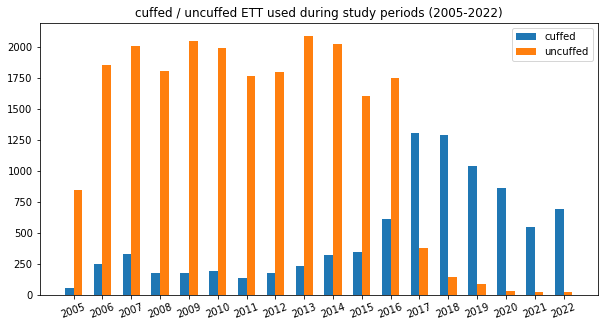

In [30]:
import matplotlib.pyplot as plt

w = 0.3
idx = np.arange(18)

plt.figure(figsize=(10,5))
plt.title('cuffed / uncuffed ETT used during study periods (2005-2022)')
plt.bar(idx-w/2, yrs_cuffed, width = w, label='cuffed')
plt.bar(idx+w/2, yrs_uncuffed, width = w, label='uncuffed')
plt.xticks(idx, np.arange(2005,2023), rotation=20)
plt.legend()
plt.show()

# COMMENT 0-4 (round down vs rounded off)

In [1]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
import pandas as pd
import xgboost as xgb
import numpy as np
import random, os, datetime, pickle
import scipy, csv, math
import matplotlib.pyplot as plt

dat = np.load(f'dataset/ETT_size-outliers3.npz')
#df = pickle.load(open('dataset/df-outliers3', 'rb'))
x, y = dat['x'], dat['y']
y_old  = dat['y_old']

# training set의 뒤쪽 20%를 test set 으로 사용 (이미 shuffle된 상태)
nsamp = len(y)
ntest = int(nsamp * 0.2)
ntrain = nsamp - ntest
x_test = x[-ntest:, :]
y_test = y[-ntest:]
y_test_old = y_old[-ntest:]
x_train = x[:ntrain, :]
y_train = y[:ntrain]

print(f'x_train: {(x_train).shape}, x_test: {x_test.shape}')


# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (24764, 5), x_test: (6190, 5)
x_train: (24764, 4), x_test: (6190, 4)


In [6]:
def evaluation(y, y_test):
    print(f'acc1 {np.mean(y == y_test)*100:.3f}, acc3 {np.mean((y >= y_test-0.5) & (y <= y_test+0.5))*100:.3f}')
    return None
    #return np.mean(y_xgbr_o == y_test), np.mean((y_xgbr_o >= y_test-0.5) & (y_xgbr <= y_test+0.5))

In [7]:
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# traditional formula
y1_trad = y_test_old == y_test
y2_trad = (y_test_old >= y_test-0.5) & (y_test_old <= y_test+0.5)
cuff_mask = x_test[:,3]==1
y1_cuff, y2_cuff = y1_trad[cuff_mask], y2_trad[cuff_mask]
y1_uncuff, y2_uncuff = y1_trad[~cuff_mask], y2_trad[~cuff_mask]

# xgbr model
print('###xgbr model###')
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/outliers+w+h/size/acc1-0.622_acc3-0.981_XGBR_4inputs_10fold/model.model')
y_xgbr = xgbr.predict(x_test)
print('rounded off:')
y_xgbr_o = np.round(y_xgbr * 2) / 2
evaluation(y_xgbr_o, y_test)
print('round down:')
y_xgbr_d = np.floor(y_xgbr * 2) / 2
evaluation(y_xgbr_d, y_test)


# RF model
print('###rfr model###')
imp = IterativeImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

rfr = pickle.load(open(f'result/outliers+w+h/size/acc1-0.606_acc3-0.980_RF_4inputs_10fold/gridSearch','rb'))
y_rfr = rfr.predict(x_test_imputed).flatten()
y_rfr_o = np.round(y_rfr * 2) / 2
print('rounded off:')
evaluation(y_rfr_o, y_test)
print('round down:')
y_rfr_d = np.floor(y_rfr * 2) / 2
evaluation(y_rfr_d, y_test)  
      

# LR model
print('###lr model###')
lr = pickle.load(open(f'result/outliers+w+h/size/acc1-0.588_acc3-0.974_LR_4inputs/model','rb'))
y_lr = lr.predict(x_test_imputed)
print('rounded off:')
y_lr_o = np.round(y_lr * 2) / 2
evaluation(y_lr_o, y_test)
print('round down:')
y_lr_d = np.floor(y_lr * 2) / 2
evaluation(y_lr_d, y_test)  

###xgbr model###
rounded off:
acc1 62.165, acc3 98.142
round down:
acc1 50.307, acc3 94.814
###rfr model###


/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/xgboost/sklearn.py:605: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  'Loading a native XGBoost model with Scikit-Learn interface.'
/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 0.24.2. Thi

rounded off:
acc1 60.565, acc3 98.029
round down:
acc1 50.840, acc3 94.540
###lr model###
rounded off:
acc1 58.772, acc3 97.415
round down:
acc1 45.073, acc3 93.473


/home/painstudy/anaconda3/envs/numbaenv/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# COMMENT 0-2 : seperate models by tube type

In [81]:
# input: age, weight, height, cuff
x_train = np.concatenate((x_train[:,0:1], x_train[:,2:5]),axis=-1)
x_test = np.concatenate((x_test[:,0:1], x_test[:,2:5]),axis=-1)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (24764, 4), x_test: (6190, 4)


In [82]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


imp = IterativeImputer().fit(x_train)
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')

x_train: (24764, 4), x_test: (6190, 4)


## Uncuffed model

In [83]:
mask = (x_train[:,3] == 0)
X_train = x_train[mask][:,:3]
Y_train = y_train[mask]

mask = (x_test[:,3] == 0)
X_test = x_test[mask][:,:3]
Y_test = y_test[mask]

Y_test_old = y_test_old[mask]
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')

X_train: (17816, 3), X_test: (4427, 3)


### Traditional

In [22]:
print('--------------')
print('old model(traditional) = age/4+4 (uncuffed)')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(Y_test, Y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(Y_test, Y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(Y_test, Y_test_old):.3f}')
print(f'r2_score: {r2_score(Y_test, Y_test_old):.3f}')

# accuracY
acc1 = np.mean(Y_test_old==Y_test)
acc3 = np.mean((Y_test_old >= Y_test-0.5) & (Y_test_old <= Y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# F1 score
yl_test = np.array([f'{i}' for i in Y_test])
yl_pred_old = np.array([f'{i}' for i in Y_test_old])
f1 = f1_score(yl_test, yl_pred_old, average='macro')
print(f'macro f1: {f1:.3f}')

--------------
old model(traditional) = age/4+4 (uncuffed)
--------------
explained_variance_score: 0.819
mean_squared_errors: 0.302
mean_absolute_errors: 0.444
r2_score: 0.660
acc: 0.273
acc(+-0.5mm): 0.840
macro f1: 0.206


In [56]:
cuff_mask = x_test[:,3]==0
y_test_old1 = y_test_old 

y1_trads, y2_trads, f1_lrs = [], [], []

print('--------------')
print('old model() = age/4+4 (uncuffed)')
print('--------------')

for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test[cuff_mask]))])
    Xg_test = (x_test[cuff_mask])[mask]
    Yg_test = (y_test[cuff_mask])[mask]
    
    y_trad = (y_test_old1[cuff_mask])[mask]
    y_trad = np.round(y_trad * 2) / 2
    y1_trads.append(np.mean(y_trad == Yg_test))
    y2_trads.append(np.mean((y_trad >= Yg_test-0.5) & (y_trad <= Yg_test+0.5)))
    
    yl_test = np.array([f'{i}' for i in Yg_test])
    yl_pred = np.array([f'{i}' for i in y_trad])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))
    
    
print(f'acc: {np.mean(y1_trads):.3f}+-{1.96*np.std(y1_trads):.3f} -> {np.mean(y1_trads)-1.96*np.std(y1_trads):.3f} ~ {np.mean(y1_trads)+1.96*np.std(y1_trads):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_trads):.3f}+-{1.96*np.std(y2_trads):.3f} -> {np.mean(y2_trads)-1.96*np.std(y2_trads):.3f} ~ {np.mean(y2_trads)+1.96*np.std(y2_trads):.3f} ')
print(f'macro f1: {np.mean(f1_lrs):.3f}+-{1.96*np.std(f1_lrs):.3f} -> {np.mean(f1_lrs)-1.96*np.std(f1_lrs):.3f} ~ {np.mean(f1_lrs)+1.96*np.std(f1_lrs):.3f}')

--------------
old model() = age/4+4 (uncuffed)
--------------
acc: 0.273+-0.013 -> 0.260 ~ 0.286
acc(+-0.5mm): 0.841+-0.010 -> 0.831 ~ 0.851 
macro f1: 0.206+-0.010 -> 0.196 ~ 0.216


In [87]:
# get length of test data
total = len(X_test)
y1_trads, y2_trads, f1_lrs = [], [], []

runs = 10000
for i in range(runs):
    # sample random indexes with replacement
    ind = np.random.randint(total, size=total)
    
    boot_x = X_test[ind]
    boot_y = Y_test[ind]
    
    y_trad = Y_test_old[ind]
    y_trad = np.round(y_trad * 2) / 2
    y1_trads.append(np.mean(y_trad == boot_y))
    y2_trads.append(np.mean((y_trad >= boot_y-0.5) & (y_trad <= boot_y+0.5)))
    
    yl_test = np.array([f'{i}' for i in boot_y])
    yl_pred = np.array([f'{i}' for i in y_trad])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))
    
    
print(f'acc: {np.mean(y1_trads):.3f}+-{1.96*np.std(y1_trads):.3f} -> {np.mean(y1_trads)-1.96*np.std(y1_trads):.3f} ~ {np.mean(y1_trads)+1.96*np.std(y1_trads):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_trads):.3f}+-{1.96*np.std(y2_trads):.3f} -> {np.mean(y2_trads)-1.96*np.std(y2_trads):.3f} ~ {np.mean(y2_trads)+1.96*np.std(y2_trads):.3f} ')
print(f'macro f1: {np.mean(f1_lrs):.3f}+-{1.96*np.std(f1_lrs):.3f} -> {np.mean(f1_lrs)-1.96*np.std(f1_lrs):.3f} ~ {np.mean(f1_lrs)+1.96*np.std(f1_lrs):.3f}')

acc: 0.273+-0.013 -> 0.260 ~ 0.286
acc(+-0.5mm): 0.840+-0.011 -> 0.830 ~ 0.851 
macro f1: 0.206+-0.010 -> 0.196 ~ 0.216


In [57]:
cuff_mask = x_test[:,3]==0
y_test_old1 = y_test_old + 0.5

y1_trads, y2_trads, f1_lrs = [], [], []

print('--------------')
print('old model(Penlington) = age/4+4.5 (uncuffed)')
print('--------------')

for i in range(200):
    mask = np.array([random.randint(0,1)==1 for j in range(len(x_test[cuff_mask]))])
    Xg_test = (x_test[cuff_mask])[mask]
    Yg_test = (y_test[cuff_mask])[mask]
    
    y_trad = (y_test_old1[cuff_mask])[mask]
    y_trad = np.round(y_trad * 2) / 2
    y1_trads.append(np.mean(y_trad == Yg_test))
    y2_trads.append(np.mean((y_trad >= Yg_test-0.5) & (y_trad <= Yg_test+0.5)))
    
    yl_test = np.array([f'{i}' for i in Yg_test])
    yl_pred = np.array([f'{i}' for i in y_trad])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))
    
    
print(f'acc: {np.mean(y1_trads):.3f}+-{1.96*np.std(y1_trads):.3f} -> {np.mean(y1_trads)-1.96*np.std(y1_trads):.3f} ~ {np.mean(y1_trads)+1.96*np.std(y1_trads):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_trads):.3f}+-{1.96*np.std(y2_trads):.3f} -> {np.mean(y2_trads)-1.96*np.std(y2_trads):.3f} ~ {np.mean(y2_trads)+1.96*np.std(y2_trads):.3f} ')
print(f'macro f1: {np.mean(f1_lrs):.3f}+-{1.96*np.std(f1_lrs):.3f} -> {np.mean(f1_lrs)-1.96*np.std(f1_lrs):.3f} ~ {np.mean(f1_lrs)+1.96*np.std(f1_lrs):.3f}')

--------------
old model(Penlington) = age/4+4.5 (uncuffed)
--------------
acc: 0.501+-0.014 -> 0.487 ~ 0.516
acc(+-0.5mm): 0.933+-0.007 -> 0.925 ~ 0.940 
macro f1: 0.407+-0.012 -> 0.395 ~ 0.419


### LR

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
y_pred = lin_model.predict(X_test)
y_pred = np.round(y_pred * 2) / 2


print(f'선형회귀 모델: 기울기 {lin_model.coef_}, 절편 {lin_model.intercept_:.3f}')
print('--------------')
print('linear regression model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(Y_test, y_pred):.3f}')


# accuracy
acc1 = np.mean(y_pred==Y_test)
acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# F1 score
yl_test = np.array([f'{i}' for i in Y_test])
yl_pred = np.array([f'{i}' for i in y_pred])
f1 = f1_score(yl_test, yl_pred, average='macro')
print(f'macro f1: {f1:.3f}')

선형회귀 모델: 기울기 [ 0.0696367  -0.00697003  0.03315853], 절편 1.676
--------------
linear regression model
--------------
explained_variance_score: 0.858
mean_squared_errors: 0.126
mean_absolute_errors: 0.228
r2_score: 0.858
acc: 0.569
acc(+-0.5mm): 0.976
macro f1: 0.484


In [24]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_f1_{f1:.3f}_LR_uncuffed'
odir = f'result/revision1/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

# 모델에 대한 정보 txt로 저장
pickle.dump(lin_model, open(f'{odir}/model', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(Y_test, y_pred):.3f}')
f.write(f'macro f1 score: {f1}')
f.close()

In [35]:
# test validation
lr = pickle.load(open(f'result/revision1/size/acc1-0.569_acc3-0.976_f1_0.484_LR_uncuffed/model','rb'))

y1_lrs, y2_lrs = [], []
f1_lrs = []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(X_test))])
    Xg_test = X_test[mask]
    Yg_test = Y_test[mask]
    
    y_lr = lr.predict(Xg_test)
    y_lr = np.round(y_lr * 2) / 2
    y1_lrs.append(np.mean(y_lr == Yg_test))
    y2_lrs.append(np.mean((y_lr >= Yg_test-0.5) & (y_lr <= Yg_test+0.5)))
    
    
    yl_test = np.array([f'{i}' for i in Yg_test])
    yl_pred = np.array([f'{i}' for i in y_lr])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))
    
print(f'acc: {np.mean(y1_lrs):.3f}+-{1.96*np.std(y1_lrs):.3f} -> {np.mean(y1_lrs)-1.96*np.std(y1_lrs):.3f} ~ {np.mean(y1_lrs)+1.96*np.std(y1_lrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_lrs):.3f}+-{1.96*np.std(y2_lrs):.3f} -> {np.mean(y2_lrs)-1.96*np.std(y2_lrs):.3f} ~ {np.mean(y2_lrs)+1.96*np.std(y2_lrs):.3f} ')
print(f'macro f1: {np.mean(f1_lrs):.3f}+-{1.96*np.std(f1_lrs):.3f} -> {np.mean(f1_lrs)-1.96*np.std(f1_lrs):.3f} ~ {np.mean(f1_lrs)+1.96*np.std(f1_lrs):.3f}')

acc: 0.569+-0.014 -> 0.555 ~ 0.583
acc(+-0.5mm): 0.976+-0.005 -> 0.971 ~ 0.980 
macro f1: 0.484+-0.013 -> 0.471 ~ 0.497


In [139]:
# test set을 recent 20%로 한 경우

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

# Create a Linear Regression model for uncuffed endotracheal tube data
lr_uncuff = LinearRegression()

# Fit the model to the training data
lr_uncuff.fit(x_uncuff_train, y_uncuff_train)

# Make predictions on the test data using the trained model
y_pred = lr_uncuff.predict(x_uncuff_test)

# Round the predicted values to the nearest 0.5 mm
y_pred = np.round(y_pred * 2) / 2

# Print the results for the Linear Regression model
print('linear regression model')
print(f'coefficient {lr_uncuff.coef_}, intercept {lr_uncuff.intercept_:.3f}')
print('--------------')


# accuracy
acc1 = np.mean(y_pred==y_uncuff_test)
acc3 = np.mean((y_pred >= y_uncuff_test-0.5) & (y_pred <= y_uncuff_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# F1 score
yl_test = np.array([f'{i}' for i in y_uncuff_test])
yl_pred = np.array([f'{i}' for i in y_pred])
f1 = f1_score(yl_test, yl_pred, average='macro')
print(f'macro f1: {f1:.3f}')

linear regression model
coefficient [0.22224768 0.01024509 0.04033785], intercept 3.510
--------------
acc: 0.449
acc(+-0.5mm): 0.953
macro f1: 0.315


In [74]:
np.percentile(y1_trads, 5), np.percentile(y1_trads, 95)

(0.4890234542444846, 0.5119307296359984)

### GBRT

In [36]:
# age (일단위)
param_dict = {
                'learning_rate': [ 0.01, 0.03, 0.05, 0.07], #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [1, 10, 30, 100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=1,
                param_grid=param_dict, cv=nfold)
gs.fit(X_train, Y_train)
model = gs.best_estimator_.get_booster()

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits


In [37]:
print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

#X_test = xgb.DMatrix(X_test)
y_pred = model.predict(X_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(Y_test, y_pred):.3f}')

# accuracy
acc1 = np.mean(y_pred==Y_test)
acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
r2 = r2_score(Y_test, y_pred)
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# F1 score
yl_test = np.array([f'{i}' for i in Y_test])
yl_pred = np.array([f'{i}' for i in y_pred])
f1 = f1_score(yl_test, yl_pred, average='macro')
print(f'macro f1: {f1:.3f}')


========= found hyperparameter =========
{'colsample_bytree': 1, 'gamma': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.5}
0.8933664679609425
--------------
new model
--------------
explained_variance_score: 0.872
mean_squared_errors: 0.114
mean_absolute_errors: 0.213
r2_score: 0.872
acc: 0.589
acc(+-0.5mm): 0.986
macro f1: 0.565


In [38]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_f1{f1:.3f}_r2-{r2:.3f}_XGBR_uncuffed_{nfold}fold'
odir = f'result/revision1/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(Y_test, y_pred):.3f}')
f.close()

* test validation

In [44]:
# test validation
xgbr = xgb.XGBRegressor()
xgbr.load_model(f'result/revision1/size/acc1-0.589_acc3-0.986_f10.565_r2-0.872_XGBR_uncuffed_10fold/model.model')

y1_lrs, y2_lrs = [], []
f1_lrs = []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(Y_test))])
    Xg_test = X_test[mask]
    Yg_test = Y_test[mask]
    
    y_lr = xgbr.predict(Xg_test)
    y_lr = np.round(y_lr * 2) / 2
    y1_lrs.append(np.mean(y_lr == Yg_test))
    y2_lrs.append(np.mean((y_lr >= Yg_test-0.5) & (y_lr <= Yg_test+0.5)))
    
    
    yl_test = np.array([f'{i}' for i in Yg_test])
    yl_pred = np.array([f'{i}' for i in y_lr])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))
    
print(f'acc: {np.mean(y1_lrs):.3f}+-{1.96*np.std(y1_lrs):.3f} -> {np.mean(y1_lrs)-1.96*np.std(y1_lrs):.3f} ~ {np.mean(y1_lrs)+1.96*np.std(y1_lrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_lrs):.3f}+-{1.96*np.std(y2_lrs):.3f} -> {np.mean(y2_lrs)-1.96*np.std(y2_lrs):.3f} ~ {np.mean(y2_lrs)+1.96*np.std(y2_lrs):.3f} ')
print(f'macro f1: {np.mean(f1_lrs):.3f}+-{1.96*np.std(f1_lrs):.3f} -> {np.mean(f1_lrs)-1.96*np.std(f1_lrs):.3f} ~ {np.mean(f1_lrs)+1.96*np.std(f1_lrs):.3f}')

acc: 0.590+-0.014 -> 0.575 ~ 0.604
acc(+-0.5mm): 0.985+-0.004 -> 0.982 ~ 0.989 
macro f1: 0.565+-0.016 -> 0.550 ~ 0.581


### comparison

In [ ]:
y1_lrs, y2_lrs = [], []
f1_lrs = []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(X_test))])
    Xg_test = X_test[mask]
    Yg_test = Y_test[mask]
    
    y_lr = lr.predict(Xg_test)
    y_lr = np.round(y_lr * 2) / 2
    y1_lrs.append(np.mean(y_lr == Yg_test))
    y2_lrs.append(np.mean((y_lr >= Yg_test-0.5) & (y_lr <= Yg_test+0.5)))
    
    y_xgbr = xgbr.predict(X_test)
    y_xgbr = np.round(y_xgbr * 2) / 2
    y1_xgbr = y_xgbr == Y_test
    y2_xgbr = (y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)
    yl_pred = np.array([f'{i}' for i in y_xgbr])
    f1_xgbr = f1_score(yl_test, yl_pred, average='macro')    
    
    
    yl_test = np.array([f'{i}' for i in Yg_test])
    yl_pred = np.array([f'{i}' for i in y_lr])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))

In [71]:
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# traditional formula
y1_trad = Y_test_old == Y_test
y2_trad = (Y_test_old >= Y_test-0.5) & (Y_test_old <= Y_test+0.5)

yl_test = np.array([f'{i}' for i in Y_test])
yl_pred = np.array([f'{i}' for i in Y_test_old])
f1_trad = f1_score(yl_test, yl_pred, average='macro')

# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/revision1/size/acc1-0.589_acc3-0.986_f10.565_r2-0.872_XGBR_uncuffed_10fold/model.model')
y_xgbr = xgbr.predict(X_test)
y_xgbr = np.round(y_xgbr * 2) / 2
y1_xgbr = y_xgbr == Y_test
y2_xgbr = (y_xgbr >= Y_test-0.5) & (y_xgbr <= Y_test+0.5)
yl_pred = np.array([f'{i}' for i in y_xgbr])
f1_xgbr = f1_score(yl_test, yl_pred, average='macro')

# LR model
lr = pickle.load(open(f'result/revision1/size/acc1-0.569_acc3-0.976_f1_0.484_LR_uncuffed/model','rb'))
y_lr = lr.predict(X_test)
y_lr = np.round(y_lr * 2) / 2
y1_lr = y_lr == Y_test
y2_lr = (y_lr >= Y_test-0.5) & (y_lr <= Y_test+0.5)
yl_pred = np.array([f'{i}' for i in y_lr])
f1_lr = f1_score(yl_test, yl_pred, average='macro')

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [72]:
# XGBR vs LR
obs1 = pd.DataFrame({'gbrt': [np.sum(y1_xgbr),np.sum(~y1_xgbr)], 'lr': [np.sum(y1_lr),np.sum(~y1_lr)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of xgbr vs lr for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr),np.sum(~y2_xgbr)], 'lr': [np.sum(y2_lr),np.sum(~y2_lr)]})
obs2.index = ['1', '0']

chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs lr for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


from scipy import stats

obs1 = pd.DataFrame({'gbrt': [np.sum(f1_xgbr),np.sum(~f1_xgbr)], 'lr': [np.sum(f1_lr),np.sum(~f1_lr)]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of xgbr vs lr for size f1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))


###Comparison of xgbr vs lr for size accuracy1###
contingency table:
   gbrt    lr
1  2609  2521
0  1818  1906
Chi square: 3.589036082269165
P-value: 0.05816197016729844

###Comparison of xgbr vs lr for size accuracy3###
contingency table:
   gbrt    lr
1  4363  4319
0    64   108
Chi square: 11.478804047936656
P-value: 0.0007039441389567039


TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# XGBR vs Penlington (uncuffed; age/4+4.5)
#y_test_old1 = y_test_old + 0.5
y1_trad = y_test_old1 == y_test
y2_trad = (y_test_old1 >= y_test-0.5) & (y_test_old1 <= y_test+0.5)


obs1 = pd.DataFrame({'gbrt': [np.sum(y1_xgbr[cuff_mask]),np.sum(~y1_xgbr[cuff_mask])], 'trad': [np.sum(y1_trad[cuff_mask]),np.sum(~y1_trad[cuff_mask])]})
obs1.index = ['1', '0']

chiresult = chi2_contingency(obs1, correction=False)
print('###Comparison of xgbr vs Penlington for size accuracy1###')
print(f'contingency table:\n{obs1}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

obs2 = pd.DataFrame({'gbrt': [np.sum(y2_xgbr[cuff_mask]),np.sum(~y2_xgbr[cuff_mask])], 'trad': [np.sum(y2_trad[cuff_mask]),np.sum(~y2_trad[cuff_mask])]})
obs2.index = ['1', '0']


chiresult = chi2_contingency(obs2, correction=False)
print('\n###Comparison of xgbr vs Penlington for size accuracy3###')
print(f'contingency table:\n{obs2}')
print('Chi square: {}'.format(chiresult[0]))
print('P-value: {}'.format(chiresult[1]))

## Cuffed model

In [51]:
mask = (x_train[:,3] == 1)
X_train = x_train[mask][:,:3]
Y_train = y_train[mask]

mask = (x_test[:,3] == 1)
X_test = x_test[mask][:,:3]
Y_test = y_test[mask]

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')

X_train: (6948, 3), X_test: (1763, 3)


### Traditional

In [30]:
Y_test_old = y_test_old[mask]

print('--------------')
print('old model(traditional) = age/4+3.5 (cuffed)')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(Y_test, Y_test_old):.3f}')
print(f'mean_squared_errors: {mean_squared_error(Y_test, Y_test_old):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(Y_test, Y_test_old):.3f}')
print(f'r2_score: {r2_score(Y_test, Y_test_old):.3f}')

# accuracY
acc1 = np.mean(Y_test_old==Y_test)
acc3 = np.mean((Y_test_old >= Y_test-0.5) & (Y_test_old <= Y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# F1 score
yl_test = np.array([f'{i}' for i in Y_test])
yl_pred_old = np.array([f'{i}' for i in Y_test_old])
f1 = f1_score(yl_test, yl_pred_old, average='macro')
print(f'macro f1: {f1:.3f}')

--------------
old model(traditional) = age/4+3.5 (cuffed)
--------------
explained_variance_score: 0.901
mean_squared_errors: 0.285
mean_absolute_errors: 0.420
r2_score: 0.742
acc: 0.294
acc(+-0.5mm): 0.883
macro f1: 0.229


### LR

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
y_pred = lin_model.predict(X_test)
y_pred = np.round(y_pred * 2) / 2


print(f'선형회귀 모델: 기울기 {lin_model.coef_}, 절편 {lin_model.intercept_:.3f}')
print('--------------')
print('linear regression model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(Y_test, y_pred):.3f}')


# accuracy
acc1 = np.mean(y_pred==Y_test)
acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# F1 score
yl_test = np.array([f'{i}' for i in Y_test])
yl_pred = np.array([f'{i}' for i in y_pred])
f1 = f1_score(yl_test, yl_pred, average='macro')
print(f'macro f1: {f1:.3f}')

선형회귀 모델: 기울기 [ 0.1017478 -0.0004596  0.023105 ], 절편 1.925
--------------
linear regression model
--------------
explained_variance_score: 0.906
mean_squared_errors: 0.104
mean_absolute_errors: 0.178
r2_score: 0.906
acc: 0.672
acc(+-0.5mm): 0.973
macro f1: 0.596


In [32]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_f1_{f1:.3f}_LR_cuffed'
odir = f'result/revision1/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)

# 모델에 대한 정보 txt로 저장
pickle.dump(lin_model, open(f'{odir}/model', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(Y_test, y_pred):.3f}')
f.write(f'macro f1 score: {f1}')
f.close()

In [33]:
# test validation
lr = pickle.load(open(f'result/revision1/size/acc1-0.672_acc3-0.973_f1_0.596_LR_cuffed/model','rb'))

y1_lrs, y2_lrs = [], []
f1_lrs = []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(X_test))])
    Xg_test = X_test[mask]
    Yg_test = Y_test[mask]
    
    y_lr = lr.predict(Xg_test)
    y_lr = np.round(y_lr * 2) / 2
    y1_lrs.append(np.mean(y_lr == Yg_test))
    y2_lrs.append(np.mean((y_lr >= Yg_test-0.5) & (y_lr <= Yg_test+0.5)))
    
    
    yl_test = np.array([f'{i}' for i in Yg_test])
    yl_pred = np.array([f'{i}' for i in y_lr])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))
    
print(f'acc: {np.mean(y1_lrs):.3f}+-{1.96*np.std(y1_lrs):.3f} -> {np.mean(y1_lrs)-1.96*np.std(y1_lrs):.3f} ~ {np.mean(y1_lrs)+1.96*np.std(y1_lrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_lrs):.3f}+-{1.96*np.std(y2_lrs):.3f} -> {np.mean(y2_lrs)-1.96*np.std(y2_lrs):.3f} ~ {np.mean(y2_lrs)+1.96*np.std(y2_lrs):.3f} ')
print(f'macro f1: {np.mean(f1_lrs):.3f}+-{1.96*np.std(f1_lrs):.3f} -> {np.mean(f1_lrs)-1.96*np.std(f1_lrs):.3f} ~ {np.mean(f1_lrs)+1.96*np.std(f1_lrs):.3f}')

acc: 0.671+-0.021 -> 0.650 ~ 0.693
acc(+-0.5mm): 0.973+-0.007 -> 0.966 ~ 0.980 
macro f1: 0.596+-0.018 -> 0.577 ~ 0.614


### GBRT

In [46]:
# age (일단위)
param_dict = {
                'learning_rate': [ 0.01, 0.03, 0.05, 0.07], #, #[0.01, 0.03, 0.05],
                'max_depth': [3, 4, 5, 7],#[3,4,5],
                'n_estimators': [25, 50, 75, 100, 300],
                'subsample': [0.5, 0.8, 1], #[0.5, 0.8, 1],
                'colsample_bytree': [0.5, 0.8, 1], #[0.8, 1],
                'gamma': [0.3, 0.5, 0.7, 0.9],
                #'scale_pos_weight': [1, 10, 30, 100]
            }
nfold = 10
gs = GridSearchCV(estimator=xgb.sklearn.XGBRegressor(),
                n_jobs=-1,
                verbose=1,
                param_grid=param_dict, cv=nfold)
gs.fit(X_train, Y_train)
model = gs.best_estimator_.get_booster()

Fitting 10 folds for each of 2880 candidates, totalling 28800 fits


In [48]:
print()
print("========= found hyperparameter =========")
print(gs.best_params_)
print(gs.best_score_)
print("========================================")

X_test = xgb.DMatrix(X_test)
y_pred = model.predict(X_test).flatten()
y_pred = np.round(y_pred * 2) / 2


print('--------------')
print('new model')
print('--------------')
print(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
print(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
print(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
print(f'r2_score: {r2_score(Y_test, y_pred):.3f}')

# accuracy
acc1 = np.mean(y_pred==Y_test)
acc3 = np.mean((y_pred >= Y_test-0.5) & (y_pred <= Y_test+0.5))
r2 = r2_score(Y_test, y_pred)
print(f'acc: {acc1:.3f}')
print(f'acc(+-0.5mm): {acc3:.3f}')

# F1 score
yl_test = np.array([f'{i}' for i in Y_test])
yl_pred = np.array([f'{i}' for i in y_pred])
f1 = f1_score(yl_test, yl_pred, average='macro')
print(f'macro f1: {f1:.3f}')


========= found hyperparameter =========
{'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
0.9300734511451868
--------------
new model
--------------
explained_variance_score: 0.919
mean_squared_errors: 0.091
mean_absolute_errors: 0.153
r2_score: 0.918
acc: 0.721
acc(+-0.5mm): 0.973
macro f1: 0.631


In [50]:
# save model
odir_f = f'acc1-{acc1:.3f}_acc3-{acc3:.3f}_f1{f1:.3f}_r2-{r2:.3f}_XGBR_cuffed_{nfold}fold'
odir = f'result/revision1/size/{odir_f}'
if not os.path.exists(odir):
    os.mkdir(odir)
model.save_model(f'{odir}/model.model')

# 모델에 대한 정보 txt로 저장
pickle.dump(param_dict, open(f'{odir}/param_dict', 'wb'))
f = open(f'{odir}/result.txt', 'w')
f.write(f'classification model')
f.write(f'explained_variance_score: {explained_variance_score(Y_test, y_pred):.3f}')
f.write(f'mean_squared_errors: {mean_squared_error(Y_test, y_pred):.3f}')
f.write(f'mean_absolute_errors: {mean_absolute_error(Y_test, y_pred):.3f}')
f.write(f'r2_score: {r2_score(Y_test, y_pred):.3f}')
f.close()

In [52]:
# test validation
xgbr = xgb.XGBRegressor()
xgbr.load_model(f'result/revision1/size/acc1-0.721_acc3-0.973_f10.631_r2-0.918_XGBR_cuffed_10fold/model.model')

y1_lrs, y2_lrs = [], []
f1_lrs = []
for i in range(200):
    
    mask = np.array([random.randint(0,1)==1 for j in range(len(Y_test))])
    Xg_test = X_test[mask]
    Yg_test = Y_test[mask]
    
    y_lr = xgbr.predict(Xg_test)
    y_lr = np.round(y_lr * 2) / 2
    y1_lrs.append(np.mean(y_lr == Yg_test))
    y2_lrs.append(np.mean((y_lr >= Yg_test-0.5) & (y_lr <= Yg_test+0.5)))
    
    
    yl_test = np.array([f'{i}' for i in Yg_test])
    yl_pred = np.array([f'{i}' for i in y_lr])
    f1_lrs.append(f1_score(yl_test, yl_pred, average='macro'))
    
print(f'acc: {np.mean(y1_lrs):.3f}+-{1.96*np.std(y1_lrs):.3f} -> {np.mean(y1_lrs)-1.96*np.std(y1_lrs):.3f} ~ {np.mean(y1_lrs)+1.96*np.std(y1_lrs):.3f}')
print(f'acc(+-0.5mm): {np.mean(y2_lrs):.3f}+-{1.96*np.std(y2_lrs):.3f} -> {np.mean(y2_lrs)-1.96*np.std(y2_lrs):.3f} ~ {np.mean(y2_lrs)+1.96*np.std(y2_lrs):.3f} ')
print(f'macro f1: {np.mean(f1_lrs):.3f}+-{1.96*np.std(f1_lrs):.3f} -> {np.mean(f1_lrs)-1.96*np.std(f1_lrs):.3f} ~ {np.mean(f1_lrs)+1.96*np.std(f1_lrs):.3f}')

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


acc: 0.722+-0.021 -> 0.701 ~ 0.742
acc(+-0.5mm): 0.973+-0.008 -> 0.966 ~ 0.981 
macro f1: 0.631+-0.018 -> 0.613 ~ 0.649


## COMMENT 3: Macro-AUROC, R^2

### loading model

In [79]:
### uncuffed
mask = (x_train[:,3] == 0)
X_train = x_train[mask]
Y_train = y_train[mask]

mask = (x_test[:,3] == 0)
X_test = x_test[mask]
Y_test = y_test[mask]

print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')


# xgbr model
xgbr = xgb.XGBRegressor()
xgbr.load_model('result/revision1/size/acc1-0.592_acc3-0.986_r2-0.873_XGBR_uncuffed_10fold/model.model')

#X_test = xgb.DMatrix(X_test)
y_xgbr = xgbr.predict((X_test)).flatten()
y_xgbr = np.round(y_xgbr * 2) / 2

# lr

X_train: (17816, 4), X_test: (4427, 4)


/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [84]:
from sklearn.preprocessing import LabelBinarizer

yl_train = np.array([f'{i}' for i in Y_train])
yl_test = np.array([f'{i}' for i in Y_test])

label_binarizer = LabelBinarizer().fit(yl_train)
y_onehot_test = label_binarizer.transform(yl_test)

### macro-auroc

In [12]:
from sklearn.preprocessing import LabelBinarizer

yl_train = np.array([f'{i}' for i in Y_train])
yl_test = np.array([f'{i}' for i in Y_test])

label_binarizer = LabelBinarizer().fit(yl_train)
y_onehot_test = label_binarizer.transform(yl_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4427, 8)

In [27]:
y_pred = np.round(y_pred * 2) / 2
y_pred = np.array([f'{i}' for i in y_pred])

y_score = label_binarizer.transform(y_pred)

In [14]:
y_score = np.array([np.array([3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]) - y_pred[i] for i in range(len(Y_test))])
#y_score = y_score - y_pred

In [24]:
y_onehot_test[:, class_id]

array([0, 0, 0, ..., 1, 0, 0])

In [25]:
y_score[:, class_id]

array([0.31492949, 1.86598635, 2.99728656, ..., 0.24630356, 1.42380524,
       2.2989397 ])

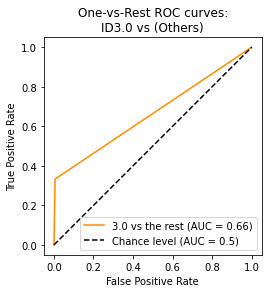

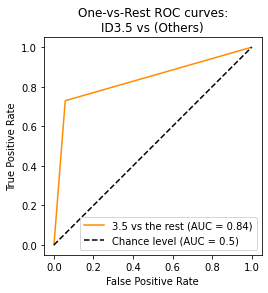

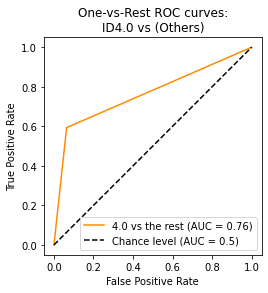

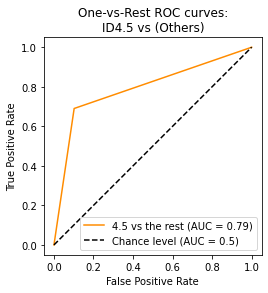

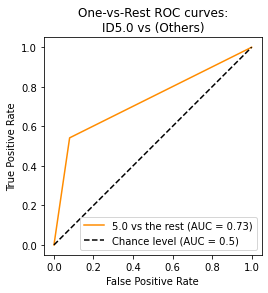

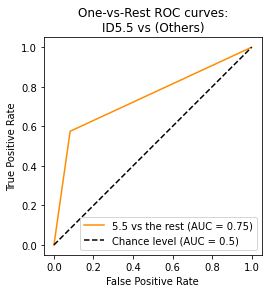

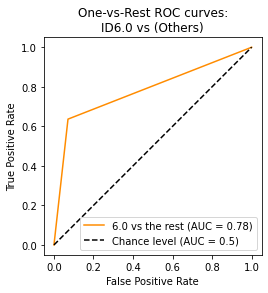

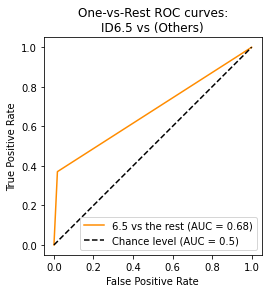

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

for i in range(len(label_binarizer.classes_)):
    class_of_interest = label_binarizer.classes_[i]
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\nID{class_of_interest} vs (Others)")
    plt.legend()
    plt.show()

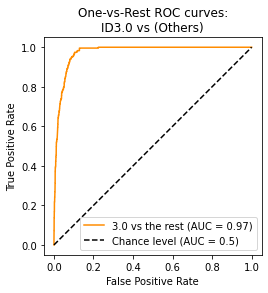

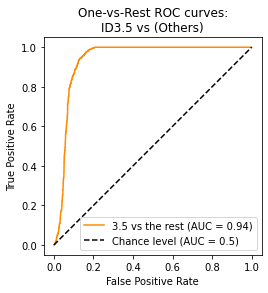

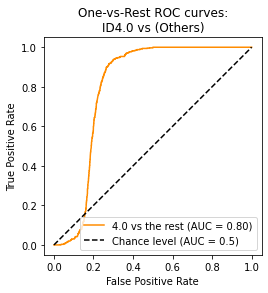

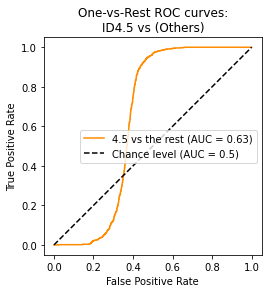

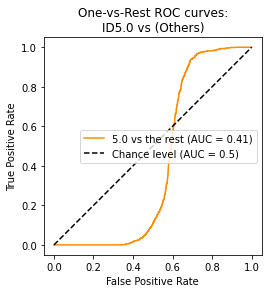

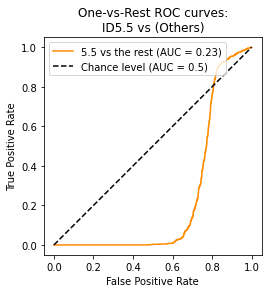

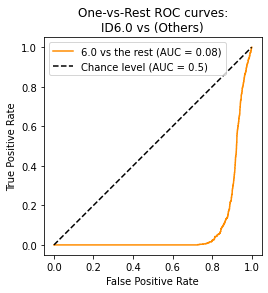

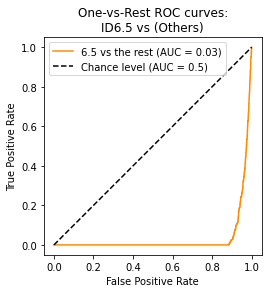

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

for i in range(len(label_binarizer.classes_)):
    class_of_interest = label_binarizer.classes_[i]
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\nID{class_of_interest} vs (Others)")
    plt.legend()
    plt.show()

In [ ]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

In [35]:
from tqdm import tqdm

def naive_roc_auc_score(y_true, y_pred):
    
    num_same_sign = 0
    num_pairs = 0

    for a in tqdm(range(len(y_true))):
        for b in range(len(y_true)):
            if y_true[a] > y_true[b]:
                num_pairs += 1
                if y_pred[a] > y_pred[b]:
                    num_same_sign += 1
                elif y_pred[a] == y_pred[b]:
                    num_same_sign += .5

    return num_same_sign / num_pairs

In [39]:
Y_test

array([6. , 5. , 3.5, ..., 6.5, 5.5, 4.5])

In [36]:
y_pred = xgbr.predict((X_test)).flatten()
labels = [i*0.5 for i in range(6, 14)]

for label in labels:
    y_true = (Y_test == label)
    print(f'ID{label} : one-vs-rest AUROC {naive_roc_auc_score(y_true, y_pred)}')

100%|██████████| 4427/4427 [00:31<00:00, 140.27it/s]


ID3.0 : one-vs-rest AUROC 0.025879008767155678


100%|██████████| 4427/4427 [00:32<00:00, 137.82it/s]


ID3.5 : one-vs-rest AUROC 0.06387896745575584


100%|██████████| 4427/4427 [00:32<00:00, 137.09it/s]


ID4.0 : one-vs-rest AUROC 0.2010924377819543


100%|██████████| 4427/4427 [00:32<00:00, 136.02it/s]


ID4.5 : one-vs-rest AUROC 0.3668193276919039


100%|██████████| 4427/4427 [00:32<00:00, 137.24it/s]


ID5.0 : one-vs-rest AUROC 0.5925160634166894


100%|██████████| 4427/4427 [00:31<00:00, 138.94it/s]


ID5.5 : one-vs-rest AUROC 0.7664424759538034


100%|██████████| 4427/4427 [00:31<00:00, 139.92it/s]


ID6.0 : one-vs-rest AUROC 0.919220303678808


100%|██████████| 4427/4427 [00:31<00:00, 142.28it/s]

ID6.5 : one-vs-rest AUROC 0.965899869570695


In [40]:
for label in labels:
    y_true = (Y_test == label)
    
    print(f'ID{label} : one-vs-rest AUROC {naive_roc_auc_score(Y_test, y_pred)}')

100%|██████████| 4427/4427 [00:07<00:00, 591.57it/s]


ID3.0 : one-vs-rest AUROC 0.9517880374368198


100%|██████████| 4427/4427 [00:07<00:00, 577.77it/s]


ID3.5 : one-vs-rest AUROC 0.9517880374368198


100%|██████████| 4427/4427 [00:07<00:00, 578.23it/s]


ID4.0 : one-vs-rest AUROC 0.9517880374368198


100%|██████████| 4427/4427 [00:07<00:00, 578.17it/s]


ID4.5 : one-vs-rest AUROC 0.9517880374368198


100%|██████████| 4427/4427 [00:07<00:00, 578.14it/s]


ID5.0 : one-vs-rest AUROC 0.9517880374368198


100%|██████████| 4427/4427 [00:07<00:00, 575.34it/s]


ID5.5 : one-vs-rest AUROC 0.9517880374368198


100%|██████████| 4427/4427 [00:07<00:00, 573.86it/s]


ID6.0 : one-vs-rest AUROC 0.9517880374368198


100%|██████████| 4427/4427 [00:07<00:00, 572.95it/s]

ID6.5 : one-vs-rest AUROC 0.9517880374368198


### macro F1-score

In [86]:
from sklearn.metrics import f1_score

yl_pred = np.array([f'{i}' for i in y_pred])
f1_score(yl_test, yl_pred, average='macro')

0.567824080860674

## COMMENT 5 (Suppl.table 2)

### Size models

In [4]:
# Linear regression model
lr_cuff = pickle.load(open(f'result/revision1/size/acc1-0.584_acc3-0.994_f1_0.575_LR_cuffed/model','rb'))
lr_uncuff = pickle.load(open(f'result/revision1/size/acc1-0.538_acc3-0.972_f1_0.409_LR_uncuffed/model','rb'))


# Gradient-boosted regression tree model
gbrt_cuff = xgb.XGBRegressor()
gbrt_cuff.load_model('result/revision1/size/acc1-0.701_acc3-0.995_f10.670_GBRT_cuffed_10fold/model.model')

gbrt_uncuff = xgb.XGBRegressor()
gbrt_uncuff.load_model('result/revision1/size/acc1-0.582_acc3-0.981_f10.497_GBRT_uncuffed_10fold/model.model')

/home/painstudy/.local/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [165]:
gbrt_cuff.predict([[age, ws[j], hs[j]]])

array([3.7265515], dtype=float32)

In [166]:
def prediction_cuffed(inp):
    # prediction of lr model
    y_lr = lr_cuff.predict([inp])
    y_lr = np.round(y_lr*2) / 2
    
    # prediction of gbrt model
    y_gbrt = gbrt_cuff.predict([inp]).flatten()
    y_gbrt = np.round(y_gbrt * 2) / 2
    
    inp.extend(y_lr)
    inp.extend(y_gbrt)
    return inp


def prediction_uncuffed(inp):
    # prediction of lr model
    y_lr = lr_uncuff.predict([inp])
    y_lr = np.round(y_lr*2) / 2
    
    # prediction of gbrt model
    y_gbrt = gbrt_uncuff.predict([inp]).flatten()
    y_gbrt = np.round(y_gbrt * 2) / 2
    
    inp.extend(y_lr)
    inp.extend(y_gbrt)
    return inp

In [151]:
df_height = pd.read_excel('growth_development.xlsx', sheet_name='신장')
df_weight = pd.read_excel('growth_development.xlsx', sheet_name='체중')

,sex,age(years),age(months),L,M,S,1st,3rd,5th,10th,...,95th,97th,99th,-3SD,-2SD,-1SD,0,+1SD,+2SD,+3SD
0,1,1,12,1.0000,75.7488,0.0314,70.2,71.3,71.8,72.7,...,79.7,80.2,81.3,68.6,71.0,73.4,75.7,78.1,80.5,82.9
1,1,2,24,1.0000,87.1161,0.0351,80.0,81.4,82.1,83.2,...,92.1,92.9,94.2,78.0,81.0,84.1,87.1,90.2,93.2,96.3
2,1,3,36,-1.0915,96.4961,0.0403,88.3,89.7,90.5,91.8,...,103.4,104.4,106.5,86.1,89.3,92.8,96.5,100.6,105.0,109.8
3,1,4,48,-0.1597,103.0749,0.0400,94.0,95.6,96.5,97.9,...,110.1,111.2,113.2,91.5,95.2,99.0,103.1,107.3,111.7,116.4
4,1,5,60,0.4242,109.5896,0.0398,99.7,101.6,102.5,104.1,...,116.9,118.0,120.0,96.9,101.1,105.3,109.6,114.0,118.5,123.1
5,1,6,72,0.1783,115.9183,0.0403,105.5,107.4,108.4,110.1,...,123.8,125.0,127.2,102.6,106.9,111.3,115.9,120.7,125.6,130.7
6,1,7,84,0.0492,122.0537,0.0406,111.0,113.1,114.2,115.9,...,130.5,131.7,134.1,108.0,112.5,117.2,122.1,127.1,132.4,137.8
7,1,8,96,0.1205,127.8793,0.0405,116.3,118.5,119.6,121.4,...,136.6,137.9,140.4,113.2,117.9,122.8,127.9,133.1,138.6,144.3
8,1,9,108,0.1885,133.4136,0.0405,121.3,123.6,124.8,126.6,...,142.5,143.9,146.5,118.0,123.0,128.1,133.4,138.9,144.6,150.4
9,1,10,120,-0.0752,138.8473,0.0417,126.0,128.4,129.7,131.6,...,148.7,150.2,153.1,122.6,127.8,133.2,138.8,144.8,151.0,157.5


In [170]:
# loading pediatric growth chart
df_height = pd.read_excel('growth_development.xlsx', sheet_name='신장')
df_weight = pd.read_excel('growth_development.xlsx', sheet_name='체중')

percentiles = ['5th', '15th', '25th', '50th', '75th', '85th', '95th']
tables_cuffed, tables_uncuffed = [], []

for i in range(24):
    sex = 2 - df_height.loc[i, 'sex']  # excel은 male 1, female 2 -> 모델은 male 1, female 0
    age = df_height.loc[i, 'age(years)']
    hs = df_height.loc[i, percentiles].values
    ws = df_weight.loc[i, percentiles].values
    
    for j in range(len(hs)):
        tables_cuffed.append(prediction_cuffed([age, sex, ws[j], hs[j]]))
        tables_uncuffed.append(prediction_uncuffed([age, ws[j], hs[j]]))

In [ ]:
pd.DataFrame(tables_cuffed, columns=['age', 'weight', 'height', 'predicted_LR', 'predicted_GBRT']).to_csv('S4_cuffed.csv')
pd.DataFrame(tables_uncuffed, columns=['age', 'weight', 'height', 'predicted_LR', 'predicted_GBRT']).to_csv('S4_uncuffed.csv')

In [75]:
# predicted size
# age, sex (MALE=1), wt, ht, uncuffed/cuffed(cuffed=1), predictedLM, predicted GBRT

tables = []

inp = [1, 8, 70, 0]
tables.append(prediction_uncuffed(inp))

inp = [1, 10, 80, 0]
tables.append(prediction_uncuffed(inp))

inp = [2, 10, 80, 0]
tables.append(prediction_uncuffed(inp))

inp = [2, 15, 90, 0]
tables.append(prediction_uncuffed(inp))

inp = [3, 15, 90, 0]
tables.append(prediction_uncuffed(inp))

inp = [3, 20, 100, 0]
tables.append(prediction_uncuffed(inp))

inp = [4, 15, 100, 0]
tables.append(prediction_uncuffed(inp))

inp = [4, 20, 110, 0]
tables.append(prediction_uncuffed(inp))

inp = [5, 15, 100, 0]
tables.append(prediction_uncuffed(inp))

inp = [5, 20, 110, 0]
tables.append(prediction_uncuffed(inp))

inp = [5, 25, 120, 0]
tables.append(prediction_uncuffed(inp))



print('[age, weight, height, un/cuffed, predicted LM, predicted GBRT]')
tables

[[1, 8, 70, 0, 4.0],
 [1, 10, 80, 0, 4.5],
 [2, 10, 80, 0, 4.5],
 [2, 15, 90, 0, 4.5],
 [3, 15, 90, 0, 5.0],
 [3, 20, 100, 0, 5.0]]

### Depth models

In [5]:
import xgboost as xgb

# Linear regression model
lr_uncuff = pickle.load(open(f'result/revision1/depth/mae-0.742_rmse-0.940_r20.803_LR_uncuff/model','rb'))

# Gradient-boosted regression tree model
gbrt_uncuff = xgb.XGBRegressor()
gbrt_uncuff.load_model('result/revision1/depth/mae-0.706_rmse-0.884_r20.831_gbrt_uncuff_10nfold/model.model')

# Linear regression model
#lr_cuff = pickle.load(open(f'result/revision1/depth/mae-0.775_rmse-1.060_r20.882_LR_cuff+sex/model','rb'))
lr_cuff = pickle.load(open(f'result/revision1/depth/mae-0.775_rmse-1.061_r20.883_LR_cuff/model','rb'))


# Gradient-boosted regression tree model
gbrt_cuff = xgb.XGBRegressor()
#gbrt_cuff.load_model('result/revision1/depth/mae-0.722_rmse-1.005_r20.902_gbrt_cuff+sex_10nfold/model.model')
gbrt_cuff.load_model('result/revision1/depth/mae-0.719_rmse-1.005_r20.903_gbrt_cuff_10nfold/model.model')


In [7]:
def prediction_cuffed(inp):
    # prediction of lr model
    y_lr = lr_cuff.predict([inp])
    
    
    # prediction of gbrt model
    y_gbrt = gbrt_cuff.predict([inp]).flatten()
    
    
    inp.extend(y_lr)
    inp.extend(y_gbrt)
    return inp


def prediction_uncuffed(inp):
    # prediction of lr model
    y_lr = lr_uncuff.predict([inp])
    
    
    # prediction of gbrt model
    y_gbrt = gbrt_uncuff.predict([inp]).flatten()
    
    
    inp.extend(y_lr)
    inp.extend(y_gbrt)
    return inp

In [11]:
asd = [age, sex, ws[j], hs[j]]
asd

[12, 0, 59.1, 161.3]

In [13]:
asd[0] + asd[2:]

array([ 71.1, 173.3])

In [9]:
# loading pediatric growth chart
df_height = pd.read_excel('growth_development.xlsx', sheet_name='신장')
df_weight = pd.read_excel('growth_development.xlsx', sheet_name='체중')

percentiles = ['5th', '15th', '25th', '50th', '75th', '85th', '95th']
tables_cuffed, tables_uncuffed = [], []

for i in range(24):
    sex = 2 - df_height.loc[i, 'sex']  # excel은 male 1, female 2 -> 모델은 male 1, female 0
    age = df_height.loc[i, 'age(years)']
    hs = df_height.loc[i, percentiles].values
    ws = df_weight.loc[i, percentiles].values
    
    for j in range(len(hs)):
        tables_cuffed.append(prediction_cuffed([age, ws[j], hs[j]]))
        tables_uncuffed.append(prediction_uncuffed([age, sex, ws[j], hs[j]]))

In [14]:
pd.DataFrame(tables_cuffed, columns=['age', 'weight', 'height', 'predicted_LR', 'predicted_GBRT']).to_csv('Suppl_T2_depth_cuffed.csv')
pd.DataFrame(tables_uncuffed, columns=['age', 'sex', 'weight', 'height', 'predicted_LR', 'predicted_GBRT']).to_csv('Suppl_T2_depth_uncuffed.csv')

# Table 1

In [3]:
print(f'total x_uncuff_train: {len(x_uncuff_train)}, x_uncuff_test: {len(x_uncuff_test)}')
# age
print(f'[age] \ntrain - mean : {np.mean(x_uncuff_train[:,0]):.2f}, std : {np.std(x_uncuff_train[:,0]):.2f}')
print(f'test - mean : {np.mean(x_uncuff_test[:,0]):.2f}, std : {np.std(x_uncuff_test[:,0]):.2f}\n')
print(f'neonate: train {np.sum(x_uncuff_train[:,0]<1/12)} ({np.sum(x_uncuff_train[:,0]<1/12)/len(x_uncuff_train):.4f}), test {np.sum(x_uncuff_test[:,0]<1/12)} ({np.sum(x_uncuff_test[:,0]<1/12)/len(x_uncuff_test):.4f})')
print(f'infant: train {np.sum((x_uncuff_train[:,0]<1)&(x_uncuff_train[:,0]>1/12))} ({np.sum((x_uncuff_train[:,0]<1)&(x_uncuff_train[:,0]>1/12))/len(x_uncuff_train):.4f}), test {np.sum((x_uncuff_test[:,0]<1)&(x_uncuff_test[:,0]>1/12))} ({np.sum((x_uncuff_test[:,0]<1)&(x_uncuff_test[:,0]>1/12))/len(x_uncuff_test):.4f})')
print(f'the others: train {np.sum(x_uncuff_train[:,0]>1)} ({np.sum(x_uncuff_train[:,0]>1)/len(x_uncuff_train):.4f}), test {np.sum(x_uncuff_test[:,0]>1)} ({np.sum(x_uncuff_test[:,0]>1)/len(x_uncuff_test):.4f})')


# sex
print(f'[sex] \ntrain - female : {len(x_uncuff_train)-np.sum(x_uncuff_train[:,1])}({1-np.mean(x_uncuff_train[:,1]):.3f}), male: {np.sum(x_uncuff_train[:,1])}({np.mean(x_uncuff_train[:,1]):.3f})')
print(f'test - female : {len(x_uncuff_test)-np.sum(x_uncuff_test[:,1])}({1-np.mean(x_uncuff_test[:,1]):.3f}), male: {np.sum(x_uncuff_test[:,1])}({np.mean(x_uncuff_test[:,1]):.3f})\n')


# weight
print(f'[weight]  mean : {np.nanmean(x_uncuff_train[:,2]):.2f}, std : {np.nanstd(x_uncuff_train[:,2]):.2f}')
print(f'test - mean : {np.nanmean(x_uncuff_test[:,2]):.2f}, std : {np.nanstd(x_uncuff_test[:,2]):.2f}\n')

# height
print(f'[height]  mean : {np.nanmean(x_uncuff_train[:,3]):.2f}, std : {np.nanstd(x_uncuff_train[:,3]):.2f}')
print(f'test - mean : {np.nanmean(x_uncuff_test[:,3]):.2f}, std : {np.nanstd(x_uncuff_test[:,3]):.2f}\n')

# tube size
print(f'[tube size] \ntrain - mean : {np.mean(y_uncuff_train):.2f}, std : {np.std(y_uncuff_train):.2f}')
print(f'test - mean : {np.mean(y_uncuff_test):.2f}, std : {np.std(y_uncuff_test):.2f}\n')

total x_uncuff_train: 18934, x_uncuff_test: 4733
[age] 
train - mean : 3.32, std : 2.83
test - mean : 2.94, std : 2.49

neonate: train 671 (0.0354), test 163 (0.0344)
infant: train 4597 (0.2428), test 1107 (0.2339)
the others: train 13666 (0.7218), test 3463 (0.7317)
[sex] 
train - female : 7811.0(0.413), male: 11123.0(0.587)
test - female : 1999.0(0.422), male: 2734.0(0.578)

[weight]  mean : 14.59, std : 7.98
test - mean : 13.67, std : 7.00



IndexError: index 3 is out of bounds for axis 1 with size 3